In [1]:
import pandas as pd
import numpy as np
import regex as re
import string
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer, StandardScaler, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline


# Data Loading:

In [2]:
movies_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
train_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

In [3]:
train_df.head()



,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [4]:
movies_df.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [5]:
test_df.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [6]:
count=CountVectorizer()

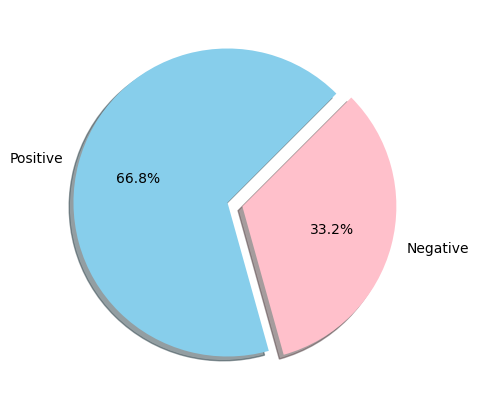

In [7]:
fig=plt.figure(figsize=(5,5))
colors=["skyblue",'pink']
pos=train_df[train_df['sentiment']=='POSITIVE']
neg=train_df[train_df['sentiment']=='NEGATIVE']
ck=[pos['sentiment'].count(),neg['sentiment'].count()]
legpie=plt.pie(ck,labels=["Positive","Negative"],
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

In [8]:
test_df.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [9]:
movies_df.drop_duplicates(subset='movieid', inplace=True)
train_df.drop_duplicates(subset=['movieid', 'reviewerName', 'reviewText'], inplace=True)

In [10]:
train_df.dropna(subset='reviewText', inplace=True)
train_df.reset_index(drop=True, inplace=True)

In [11]:
movies_df.reset_index(drop=True, inplace=True)

# Merge Metadata:

In [12]:
data = pd.merge(train_df, movies_df, on='movieid', how='left') 

test_df = pd.merge(test_df, movies_df, on='movieid', how='left')

In [13]:
tgt = data['sentiment']
data = data[[ 'reviewText', 'rating', 'genre', 'ratingContents', 'audienceScore', 'distributor','boxOffice','releaseDateStreaming', 'releaseDateTheaters','director', 'soundType', 'runtimeMinutes', 'originalLanguage']]

In [14]:
data['genre'].nunique()

1157

In [15]:
data

,reviewText,rating,genre,ratingContents,audienceScore,distributor,boxOffice,releaseDateStreaming,releaseDateTheaters,director,soundType,runtimeMinutes,originalLanguage
0,Henry Selick’s first movie since 2009’s Corali...,PG-13,"Comedy, Animation, Adventure, Fantasy","['Violence', 'Brief Strong Language', 'Substan...",65.0,Netflix,NaN,2022-10-28,2022-10-21,Bennie Basso,NaN,105.0,English
1,With a cast that reads like the Vogue Oscar pa...,NaN,Action,NaN,NaN,NaN,NaN,2013-01-08,NaN,Alma White,NaN,91.0,English
2,Creed II does not give us anything but another...,PG-13,Drama,"['Language', 'A Scene of Sensuality', 'Sports ...",80.0,"Warner Bros. Pictures, Metro-Goldwyn-Mayer",$115.7M,2019-02-12,2018-11-21,Bobby Oleary,NaN,130.0,English
3,"I know what you're thinking, but this is no Li...",NaN,Drama,NaN,NaN,NaN,NaN,2020-06-02,NaN,Eric Hutcherson,NaN,15.0,Spanish
4,Director Fernando Meirelles tells the story wi...,R,"Crime, Drama","['Language', 'Drug Content', 'Sexuality', 'Str...",97.0,Miramax Films,$7.6M,2004-06-08,2003-01-17,John Trent,"Surround, Dolby SR, Dolby Digital, Dolby A, Do...",131.0,Portuguese (Brazil)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155237,A top-notch thriller with genuine surprises an...,NaN,Romance,NaN,NaN,NaN,NaN,2004-01-06,NaN,Gertrude Fonner,NaN,96.0,English
155238,Some people find Derek Zoolander funny and lik...,PG-13,"Comedy, Adventure","['Crude and Sexual Content', 'Brief Strong Lan...",20.0,Paramount Pictures,$28.8M,2016-05-24,2016-02-12,Susan Oley,NaN,102.0,English
155239,"This fun, gentle comedy focuses mainly on them...",PG-13,"Comedy, Drama","['Some Language', 'Suggestive References']",78.0,NaN,NaN,2022-06-17,NaN,Bryant Reams,Dolby Digital,90.0,English
155240,"The film is rescued by a strong third act, but...",NaN,"Kids & family, Holiday, Comedy",NaN,39.0,20th Century Fox,$60.6M,1998-11-03,1996-11-16,Lisa Cruz,Surround,88.0,English


In [16]:
test_df = test_df[[ 'reviewText', 'rating', 'genre', 'ratingContents', 'audienceScore', 'distributor','boxOffice','releaseDateStreaming', 'releaseDateTheaters','director', 'soundType', 'runtimeMinutes', 'originalLanguage']]

In [17]:
lb = LabelBinarizer()
tgt = lb.fit_transform(tgt)
tgt = tgt.ravel()


In [18]:
import pandas as pd
from scipy.stats import chi2_contingency

categorical_columns = ['rating', 'genre', 'ratingContents', 'audienceScore', 'distributor','boxOffice','releaseDateStreaming', 'releaseDateTheaters','director', 'soundType', 'runtimeMinutes', 'originalLanguage']
results = []

for col in categorical_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(data[col],tgt)
    
    # Perform the Chi-squared test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    
    results.append({
        'Column': col,
        'Chi-squared': chi2_stat,
        'P-value': p_val
    })

results_df = pd.DataFrame(results)
print(results_df)
 

                  Column   Chi-squared        P-value
0                 rating    476.523185  9.572574e-100
1                  genre  11135.011390   0.000000e+00
2         ratingContents  24670.117810   0.000000e+00
3          audienceScore  14682.535457   0.000000e+00
4            distributor  10173.655346   0.000000e+00
5              boxOffice  17408.843160   0.000000e+00
6   releaseDateStreaming  13402.846866   0.000000e+00
7    releaseDateTheaters  17004.542488   0.000000e+00
8               director  36423.375288   0.000000e+00
9              soundType   3970.809972   0.000000e+00
10        runtimeMinutes   1667.807629  8.410127e-223
11      originalLanguage   2022.574197   0.000000e+00


In [19]:
X_train, X_test, y_train, y_test = train_test_split(data, tgt, test_size=0.2, shuffle=True, stratify=tgt, random_state=42)

In [20]:
class TextProcessor(BaseEstimator, TransformerMixin):
    stop_words = set(ENGLISH_STOP_WORDS)
    stop_words.update(['film', 'films', 'movie', 'movies', 'director', 'plot', 'story', 'actor', 'actors', 'cast',
                       'scene', 'scenes', 'cinema', 'hollywood', 'script', 'screenplay', 'character', 'charaters', 'role',
                       'roles', 'actress', 'actresses', 'genre', 'genres', 'sequel', 'prequel', 'remake', 'remakes', 'original',
                       'version', 'versions', 'franchise', 'franchises', 'cinematography', 'cinematographer', 'cinematographers',
                       'cinematographic', 'cinematographics', 'cinematic', 'cinematics', 'cinematograph', 'cinematographs', 
                       'cinematographical', 'cinematographically', 'like', 'just', 'review', 'reviews', 'storyline', 'storylines',
                       'story', 'stories', 'plotline', 'dont', 'didnt', 'doesnt', 'cant', 'couldnt', 'wouldnt', 'shouldnt', 'wont',
                       'just', 'isnt', 'arent', 'wasnt', 'werent', 'havent', 'hasnt', 'hadnt', 'having', 'got', 'get',
                       'gets', 'gotten', 'im', 'ive', 'id', 'ill', 'youre', 'youve', 'youll', 'youd', 'theyre', 'theyve',
                       'theyll', 'theyd', 'weve', 'wed', 'were', 'wasnt'
                      ])
    

    process_pattern = re.compile(r"\s|[.,?!;:-_]")
    whitespace_pattern = re.compile(r"\s+")
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: pd.Series, y=None, stem=False):
        X = X.copy()
        X.fillna("", inplace=True)
        X = X.apply(self.process_text)
        return X
    
    def process_text(self, text):
        text = text.lower()

        words_without_apostrophe = []
        for word in text.split():
            if "'" not in word:
                words_without_apostrophe.append(word)
        text = " ".join(words_without_apostrophe)

        text_characters = []
        for character in text:
            if character.isalpha() or character.isspace():
                text_characters.append(character)
        text = "".join(text_characters)

        words = []
        for word in text.split():
            if len(word) > 2 and word not in self.stop_words:
                words.append(word)
        text = " ".join(words)

        whitespace_removed = []
        words = text.split()
        for word in words:
            if word:
                whitespace_removed.append(word)
        text = " ".join(whitespace_removed)

        return text




In [21]:
class DirectorProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['director'] = X_copy['director'].str.split(', ')
        X_copy['director'] = X_copy['director'].apply(lambda x: '|'.join(map(str, x)) if isinstance(x, list) else x)
        return X_copy

In [22]:

class BoxOfficeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(str)
        return X.apply(self.convert_bo)
    
    def convert_bo(self, x):
        if isinstance(x, str):
            x = x.replace('$', '')
            x = x.replace(',', '')
            if x == 'R':
                x = x.replace('R', '')
                return float(x) 
            elif x.endswith('K'):
                x = x.replace('K', '')
                return float(x) * 1000
            elif x.endswith('M'):
                x = x.replace('M', '')
                return float(x) * 1000000
            elif x.endswith('B'):
                x = x.replace('B', '')  
                return float(x) * 1000000000
            else:
                return float(x)
            print(str)
        else:
            return np.nan

In [23]:
text_pipeline = Pipeline([
    ('text_processor', TextProcessor()),         
    ('tfidf_vectorizer', TfidfVectorizer(stop_words='english'))
])

In [24]:
text_cat_pipeline = Pipeline([
    ('text_processor', TextProcessor()),         
    ('count', CountVectorizer())    
])

In [25]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())   
])

In [26]:
box_office_pipeline = Pipeline([
    ('box_office_transformer', BoxOfficeTransformer()),
    ('reshape', FunctionTransformer(lambda x: x.values.reshape(-1,1), validate=False)),
    ('num', numeric_pipeline)
])

In [27]:
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('scaler', StandardScaler(with_mean=False)),
#     ('director_processor', DirectorProcessor()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))

])

In [28]:
preprocessor = ColumnTransformer([
    ('reviewText', text_pipeline, 'reviewText'),
    ('genre', text_cat_pipeline, 'genre'),
    ('ratingContents', text_cat_pipeline, 'ratingContents'),
    ('numeric', numeric_pipeline, ['audienceScore', 'runtimeMinutes']),
    ('boxoffice', box_office_pipeline, 'boxOffice'),
    ('categorical', categorical_pipeline, ['rating', 'director', 'distributor', 'releaseDateStreaming', 'releaseDateTheaters', 'soundType', 'originalLanguage']),
])

# Feature Engineering:

In [29]:
# Performing oversampling on the training data
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [30]:
from sklearn.feature_selection import SelectKBest, SelectPercentile

skb = SelectKBest(k=1000)
k_percentile = SelectPercentile(percentile=25)
# k_percentile = SelectPercentile(score_func=mutual_info_classif, percentile=25)



In [31]:
from sklearn.feature_selection import SelectFromModel, mutual_info_classif

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
#     ('skb', skb),
    ('k_percentile', k_percentile),
#     ('feature_selector', SelectKBest(score_func=mutual_info_classif, k=10)),
#     ('feature_selector', feature_selector),
    ('logreg', LogisticRegression(max_iter=100000))
])

logreg_pipeline.fit(X_train, y_train)

accuracy = logreg_pipeline.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")



Accuracy: 0.82


In [32]:
# ensemble models
bagging_model = BaggingClassifier(base_estimator=logreg_pipeline['logreg'], n_estimators=10, random_state=42)
boosting_model = AdaBoostClassifier(base_estimator=logreg_pipeline['logreg'], n_estimators=50, random_state=42)

# final ensembled pipelines
bagging_pipeline = make_pipeline(logreg_pipeline['preprocessor'], bagging_model)
boosting_pipeline = make_pipeline(logreg_pipeline['preprocessor'], boosting_model)

# Fit and evaluate the bagging pipeline
bagging_pipeline.fit(X_train, y_train)
bagging_predictions = bagging_pipeline.predict(X_test)
bagging_accuracy = accuracy_score(y_test, bagging_predictions)
print(f'Bagging Accuracy: {bagging_accuracy:.2f}')

# Fit and evaluate the boosting pipeline
boosting_pipeline.fit(X_train, y_train)
boosting_predictions = boosting_pipeline.predict(X_test)
boosting_accuracy = accuracy_score(y_test, boosting_predictions)
print(f'Boosting Accuracy: {boosting_accuracy:.2f}')


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Accuracy: 0.82


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Boosting Accuracy: 0.71


In [33]:
# from sklearn.ensemble import GradientBoostingClassifier

# # Define the Gradient Boosting Classifier pipeline
# gb_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('k_percentile', k_percentile),  # If you're using feature selection
#     ('gb_classifier', GradientBoostingClassifier())
# ])

# # Fit the Gradient Boosting Classifier pipeline on the training data
# gb_pipeline.fit(X_train, y_train)

# # Predict sentiments on the test data
# predictions = gb_pipeline.predict(X_test)

# accuracy = gb_pipeline.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")

In [34]:
# cross-validation
cv_scores = cross_val_score(logreg_pipeline, X_train, y_train, cv=5, scoring='accuracy')

cv_scores
cv_scores.mean()

0.8151747661575541

In [35]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict 
predictions = logreg_pipeline.predict(X_test)

#classification report
class_labels = ["Negative", "Positive"]
classification_rep = classification_report(y_test, predictions, target_names=class_labels)
print("Classification Report:\n", classification_rep)

# AUC-ROC score
y_prob = logreg_pipeline.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob[:, 1]) 
print("AUC-ROC Score:", roc_auc)


Classification Report:
               precision    recall  f1-score   support

    Negative       0.77      0.64      0.70     10247
    Positive       0.84      0.91      0.87     20802

    accuracy                           0.82     31049
   macro avg       0.80      0.77      0.78     31049
weighted avg       0.81      0.82      0.81     31049

AUC-ROC Score: 0.8818032286402411


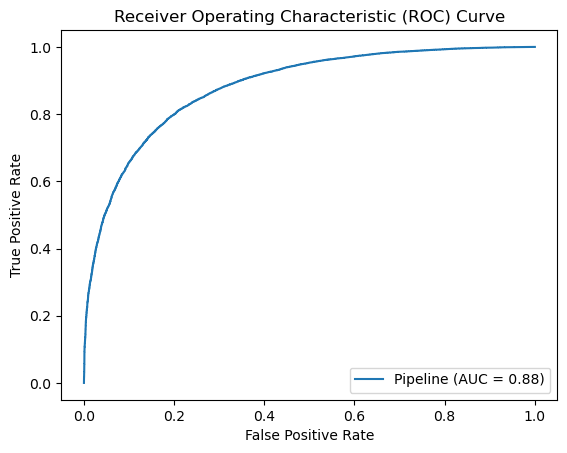

In [36]:
# Plot ROC curve
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_estimator(logreg_pipeline, X_test, y_test)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


In [37]:
# from sklearn.ensemble import RandomForestClassifier
# random_forest_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('random_forest', RandomForestClassifier())  # Use RandomForestClassifier
# ])

# random_forest_pipeline.fit(X_train, y_train)
# accuracy = random_forest_pipeline.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")


In [38]:
# from sklearn.neighbors import KNeighborsClassifier

# knn_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('knn', KNeighborsClassifier())  # Use KNeighborsClassifier
# ])

# knn_pipeline.fit(X_train, y_train)
# accuracy = knn_pipeline.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")


In [39]:
# svm_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('svm', SVC())  # Use SVC (Support Vector Machine) classifier
# ])

# svm_pipeline.fit(X_train, y_train)
# accuracy = svm_pipeline.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")


# CART

In [40]:
# from sklearn.tree import DecisionTreeClassifier


# decision_tree_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('decision_tree', DecisionTreeClassifier())  # Use DecisionTreeClassifier
# ])

# decision_tree_pipeline.fit(X_train, y_train)
# accuracy = decision_tree_pipeline.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")


In [41]:
X_test.columns

Index(['reviewText', 'rating', 'genre', 'ratingContents', 'audienceScore',
       'distributor', 'boxOffice', 'releaseDateStreaming',
       'releaseDateTheaters', 'director', 'soundType', 'runtimeMinutes',
       'originalLanguage'],
      dtype='object')

In [42]:
col = ['reviewText', 'rating', 'genre', 'ratingContents', 'audienceScore',
       'distributor', 'boxOffice', 'releaseDateStreaming',
       'releaseDateTheaters', 'director', 'soundType', 'runtimeMinutes',
       'originalLanguage']

In [43]:
# from lightgbm import LGBMClassifier

# lgbm_pipe = Pipeline([
#     ('preprocessor', preprocessor),
#     ('skb', skb),
#     ('lgbm', LGBMClassifier(num_leaves=1000,max_depth=1000,n_jobs=-1,verbose=3,force_col_wise=True))
# ])
# lgbm_pipe.fit(X_train,y_train)
# lgbm_pipe.fit(X_test,y_test)


# # Perform cross-validation
# cv_scores = cross_val_score(lgbm_pipe, X_train, y_train, cv=5, scoring='accuracy')
# cv_scores
# cv_scores.mean()

In [44]:
param_grid = {
#     'k_percentile__percentile': [10, 20, 30, 40, 50],
#     'logreg__C': [0.1, 1, 10, 100, 1000],
#     'logreg__penalty': ['l2'],
#     'logreg__solver': ['liblinear', 'lbfgs', 'sag', 'saga', 'newton-cg'],
    'logreg__max_iter': [1000],
#     'k_percentile__percentile': [10],
    'logreg__C': [ 1],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['liblinear'],
}



In [45]:
grid_search_lr = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose = 3
)

# Fit the grid search to the training data
grid_search_lr.fit(X_train, y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('reviewText',
                                                                         Pipeline(steps=[('text_processor',
                                                                                          TextProcessor()),
                                                                                         ('tfidf_vectorizer',
                                                                                          TfidfVectorizer(stop_words='english'))]),
                                                                         'reviewText'),
                                                                        ('genre',
                                                                         Pipeline(steps=[('text_processor',
                                                                                          TextProcessor()),
                                                                                         ('count',
                                                                                          CountVectorizer())]),
                                                                         'genre'),
                                                                        ('ratingContents',
                                                                         P...
                                                                          'director',
                                                                          'distributor',
                                                                          'releaseDateStreaming',
                                                                          'releaseDateTheaters',
                                                                          'soundType',
                                                                          'originalLanguage'])])),
                                       ('k_percentile',
                                        SelectPercentile(percentile=25)),
                                       ('logreg',
                                        LogisticRegression(max_iter=100000))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1], 'logreg__max_iter': [1000],
                         'logreg__penalty': ['l2'],
                         'logreg__solver': ['liblinear']},
             scoring='accuracy', verbose=3)

In [46]:
# Print the best parameters and best score
print("Best parameters:", grid_search_lr.best_params_)
print("Best score:", grid_search_lr.best_score_)

Best parameters: {'logreg__C': 1, 'logreg__max_iter': 1000, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best score: 0.8151667133310901


In [47]:
scores = grid_search_lr.cv_results_
scores = pd.DataFrame(scores)


In [48]:
# Assuming you've completed your grid search and obtained the best estimator
best_estimator = grid_search_lr.best_estimator_

In [49]:
# Make predictions using the best estimator on the processed test data
predictions = best_estimator.predict(test_df)

In [50]:
predictions.shape

(55315,)

In [51]:
# Step 7: Generate predictions for the test data and create submission file

sentiment_mapping = {0: 'NEGATIVE', 1: 'POSITIVE'}
submission_df = pd.DataFrame(columns=['id', 'sentiment'])

submission_df['id'] = [i for i in range(len(predictions))]
submission_df['sentiment'] = [i for i in predictions ]
submission_df['sentiment'] = submission_df['sentiment'].map(sentiment_mapping)

submission_df.to_csv("submission.csv", index=False)
